# Analysis of Salary Requirements and Inflation (2018–2025)

## Introduction

The Finnish Immigration Service (Migri) updates the minimum salary requirements annually. For individuals and organizations affected by these changes, staying informed about trends and predictions is crucial.

This notebook analyzes salary requirements for various residence permits, such as the Specialist, or the EU Blue Card, alongside inflation data in Finland from 2018 to 2025. The goal is to uncover trends and provide a foundation for forecasting future salary requirements.

### Import libraries and setup

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. Load Minimum Salary Data (2018-2025)

In [28]:
min_salaries_file_path = '../data/migri_residence_premit_salary_requirements_2018_2025.csv'
min_salaries_df = pd.read_csv(min_salaries_file_path)
min_salaries_df['archive_date'] = pd.to_datetime(min_salaries_df['archive_date'], format='%d.%m.%Y')

In [29]:
print("Data Preview:")
min_salaries_df.sample(5)

Data Preview:


,archive_date,year,amount,type,archive_url
24,2018-12-14,2018,4663,eu-n-sininenkortti,https://web.archive.org/web/20181214215534/htt...
7,2019-01-17,2019,3000,erityisasiantuntija,https://web.archive.org/web/20190624142622/htt...
16,2022-01-25,2022,4929,eu-n-sininenkortti,https://web.archive.org/web/20220125055137/htt...
10,2024-12-04,2024,3638,eu-n-sininenkortti,https://web.archive.org/web/20241204000843/htt...
2,2023-03-27,2023,3473,erityisasiantuntija,https://web.archive.org/web/20230327221202/htt...


In [30]:
# Dictionary for translation
translation_dict = {
    'tyontekijan-oleskelulupa': 'Residence permit application for an employed person (TTOL)',
    'erityisasiantuntija': 'Specialist',
    'eu-n-sininenkortti': 'EU Blue Card'
}

# Add the new column with translations
min_salaries_df['type_en'] = min_salaries_df['type'].map(translation_dict)

min_salaries_df.sample(5)

,archive_date,year,amount,type,archive_url,type_en
20,2020-04-06,2020,4852,eu-n-sininenkortti,https://web.archive.org/web/20200406152945/htt...,EU Blue Card
22,2019-06-25,2019,4732,eu-n-sininenkortti,https://web.archive.org/web/20190625025704/htt...,EU Blue Card
5,2021-02-28,2021,3000,erityisasiantuntija,https://web.archive.org/web/20210228131909/htt...,Specialist
31,2020-05-11,2020,1236,tyontekijan-oleskelulupa,https://web.archive.org/web/20200511075353/htt...,Residence permit application for an employed p...
21,2019-12-06,2019,4732,eu-n-sininenkortti,https://web.archive.org/web/20191206114305/htt...,EU Blue Card


In [31]:
print("\nData Information:")
min_salaries_df.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   archive_date  34 non-null     datetime64[ns]
 1   year          34 non-null     int64         
 2   amount        34 non-null     int64         
 3   type          34 non-null     object        
 4   archive_url   34 non-null     object        
 5   type_en       34 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.7+ KB


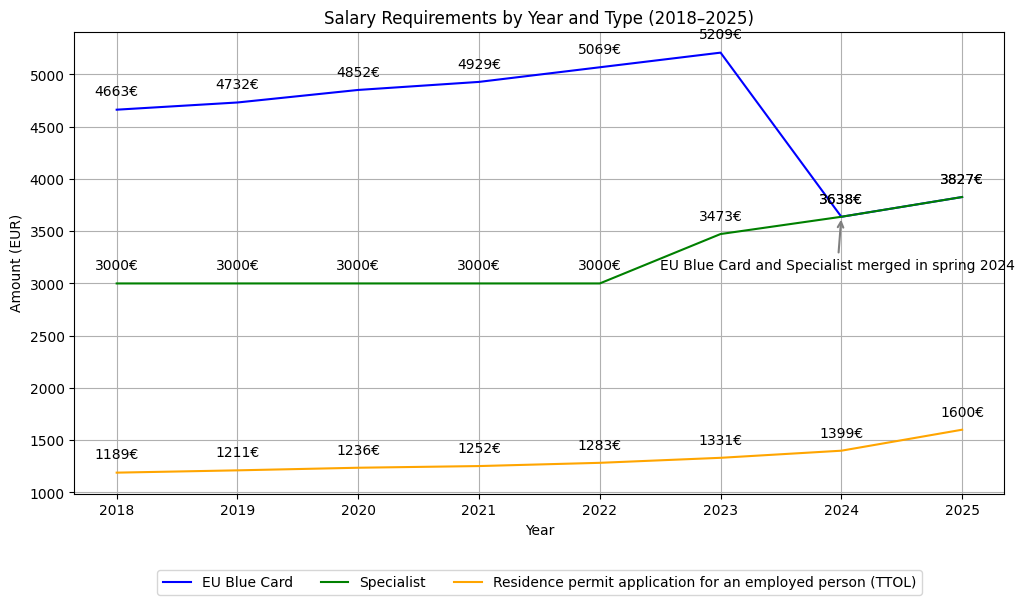

In [32]:
# Sort by year and archive_date to get the latest entry for each year
latest_salaries_df = min_salaries_df.sort_values(by=['year', 'archive_date'], ascending=[True, False]).drop_duplicates(subset=['year', 'type'])

# Define colors for each type
colors_dic = {
    'EU Blue Card': 'blue',
    'Specialist': 'green',
    'Residence permit application for an employed person (TTOL)': 'orange'
}

# Plot the data
plt.figure(figsize=(12, 6))
for key, grp in latest_salaries_df.groupby('type_en'):
    plt.plot(grp['year'], grp['amount'], label=key, color=colors_dic[key])
    for _, row in grp.iterrows():
        plt.annotate(f"{row['amount']}€", (row['year'], row['amount']), textcoords="offset points", xytext=(0,10), ha='center')

for _, row in latest_salaries_df.iterrows():
    if row['year'] == 2024 and row['type_en'] == 'Specialist':
        plt.annotate(f"EU Blue Card and Specialist merged in spring 2024",
                     xy=(row['year'], row['amount']),
                     xytext=(row['year'] - 1.5, row['amount'] - 500),
                     arrowprops=dict(arrowstyle='->', lw=1.5, color='gray'))

plt.xlabel('Year')
plt.ylabel('Amount (EUR)')
plt.title('Salary Requirements by Year and Type (2018–2025)')

# Custom legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index('EU Blue Card'), labels.index('Specialist'), labels.index('Residence permit application for an employed person (TTOL)')]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

plt.grid(True)
plt.show()

## Part 2. Load Consumer Price Index Data (2018-2024)

The Consumer Price Index (CPI) tracks the average change over time in the prices paid by consumers for a basket of goods and services. It is a key indicator of inflation, used to assess changes in purchasing power and the cost of living. The CPI is calculated by comparing current prices to those in a base year, set to an index value of 100.

In this analysis, CPI data from Statistics Finland is gathered via their API using a Python script located at `scripts/consumer_price_index_query.py`. The data covers monthly CPI values for 2018 to 2024, based on a fixed index (2015 = 100). The results are saved in `data/consumer_price_index.csv` for further processing. By aggregating monthly data, annual averages are calculated to enable consistent comparisons across years and assess inflation trends.

In [33]:
import subprocess

# Call the script to get fresh CPI data
subprocess.run(['python', '../scripts/consumer_price_index_query.py'])

CompletedProcess(args=['python', '../scripts/consumer_price_index_query.py'], returncode=1)

In [34]:
cpi_file_path = '../data/consumer_price_index.csv'
cpi_df = pd.read_csv(cpi_file_path)
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])
cpi_df['Year'] = cpi_df['Date'].dt.year
cpi_df = cpi_df[cpi_df['Year'] >= 2017]
cpi_df.info()

print("\nData Preview:")
cpi_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 95 entries, 24 to 118
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    95 non-null     datetime64[ns]
 1   CPI     95 non-null     float64       
 2   Year    95 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 2.6 KB

Data Preview:


,Date,CPI,Year
93,2022-10-01,115.99,2022
62,2020-03-01,103.49,2020
94,2022-11-01,117.40,2022
75,2021-04-01,105.26,2021
41,2018-06-01,102.32,2018


### Calculating Annual Consumer Price Index (CPI)

To calculate the **annual Consumer Price Index (CPI)** from the monthly data, I aggregate the CPI values for all 12 months of each year and compute their average. This is done using the following formula:

$$
\text{Annual CPI} = \frac{\sum \text{Monthly CPI}}{12}
$$

The steps are as follows:
1. Sum the monthly CPI values for each year.
2. Divide the total by 12 (the number of months in a year).

This approach accounts for seasonal variations in prices and ensures a consistent yearly CPI value, making it suitable for comparing inflation trends across years. 


In [35]:
annual_cpi_df = cpi_df.groupby('Year')['CPI'].mean().reset_index()
annual_cpi_df.columns = ['Year', 'Annual CPI']

print("\nAnnual CPI Data:")
display(annual_cpi_df)


Annual CPI Data:


,Year,Annual CPI
0,2017,101.108333
1,2018,102.204167
2,2019,103.250833
3,2020,103.550833
4,2021,105.823333
5,2022,113.361667
6,2023,120.447500
7,2024,122.328182


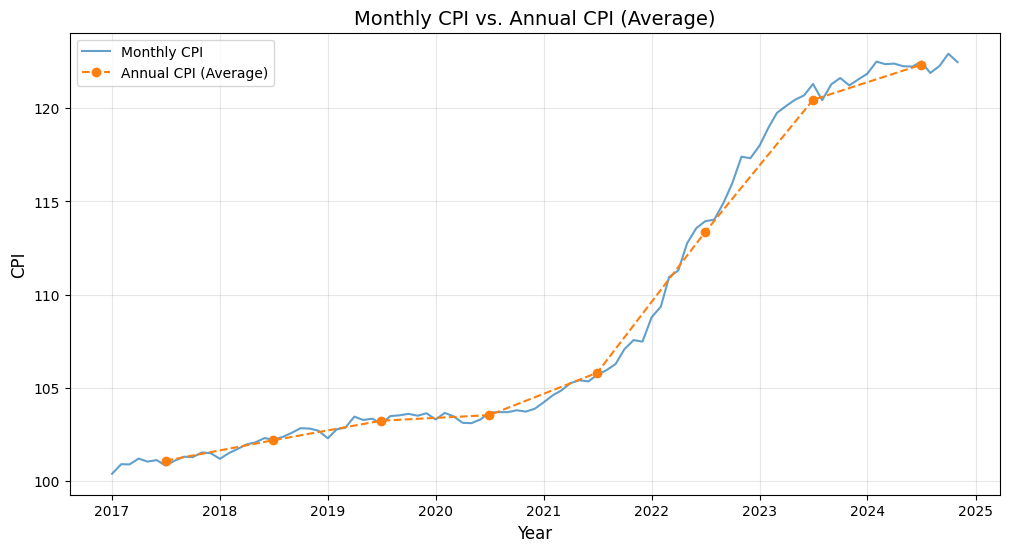

In [36]:
# Convert the 'Date' column in cpi_df to datetime if not already done
cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])

# Create the plot
plt.figure(figsize=(12, 6))

# Plot monthly CPI
plt.plot(cpi_df['Date'], cpi_df['CPI'], label='Monthly CPI', linestyle='-', alpha=0.7)

# Plot annual CPI (align to the middle of each year)
annual_cpi_df['Year_Mid'] = pd.to_datetime(annual_cpi_df['Year'].astype(str) + '-07-01')
plt.plot(annual_cpi_df['Year_Mid'], annual_cpi_df['Annual CPI'], label='Annual CPI (Average)', marker='o', linestyle='--')

# Add labels and legend
plt.title('Monthly CPI vs. Annual CPI (Average)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CPI', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


## Part 3. Matching Salary Requirements with Inflation Trends

To adjust minimum salaries accurately, we use two CPI metrics: the **CPI of the last month of the previous year** and the **average CPI of the previous year**, as both represent the inflation trends influencing salary policies. The adjusted salary is calculated as:

$$
\text{Adjusted Amount} = \text{Original Amount} \times \left(\frac{\text{Latest CPI}}{\text{CPI of Beginning}}\right)
$$

Here, **CPI of Beginning** refers to either the **CPI of the last month of the previous year** or the **average CPI of the previous year**.


In [67]:
# Create a DataFrame for the beginning CPI of each year (2018–2025)
cpi_beginning_of_year_df = pd.DataFrame()

# Extract the year and month from the Date column
cpi_df['Year'] = cpi_df['Date'].dt.year
cpi_df['Month'] = cpi_df['Date'].dt.month

# Calculate the CPI for the last available month of the previous year
# Determine the last available month for each year
last_months = cpi_df.groupby('Year')['Month'].max().reset_index()

# Merge to get the CPI values for the last available month of each year
cpi_last_month = pd.merge(cpi_df, last_months, on=['Year', 'Month'])[['Year', 'CPI']].copy()
    
cpi_last_month['Year'] = cpi_last_month['Year'] + 1  # Shift to represent the next year
cpi_last_month.rename(columns={'CPI': 'CPI of Last Month of Previous Year'}, inplace=True)

# Calculate the average CPI for each year (handle incomplete data for 2024)
cpi_avg = cpi_df.groupby('Year')['CPI'].mean().reset_index()
cpi_avg.rename(columns={'CPI': 'Average CPI of Previous Year'}, inplace=True)

# Shift the average CPI to represent the next year's influence
cpi_avg['Year'] = cpi_avg['Year'] + 1

# Merge both columns into the CPI beginning DataFrame
cpi_beginning_of_year_df = pd.merge(cpi_last_month, cpi_avg, on='Year', how='outer')

# Inspect the resulting DataFrame
display(cpi_beginning_of_year_df)


,Year,CPI of Last Month of Previous Year,Average CPI of Previous Year
0,2018,101.51,101.108333
1,2019,102.71,102.204167
2,2020,103.65,103.250833
3,2021,103.89,103.550833
4,2022,107.49,105.823333
5,2023,117.32,113.361667
6,2024,121.54,120.447500
7,2025,122.47,122.328182


Figure 3 - Annual CPI vs. Minimum Salary Requirements for Residence Permits (2015-2025)

In [69]:
# Sort by year and archive_date to get the latest entry for each year and type
latest_salaries_df = min_salaries_df.sort_values(by=['year', 'archive_date'], ascending=[True, False])
latest_salaries_df = latest_salaries_df.drop_duplicates(subset=['year', 'type_en'])

# Merge salary data with CPI information
salaries_with_cpi_df = latest_salaries_df.merge(
    cpi_beginning_of_year_df[['Year', 'CPI of Last Month of Previous Year', 'Average CPI of Previous Year']],
    left_on='year',
    right_on='Year',
    how='left'
)

# Inspect the resulting DataFrame
display(salaries_with_cpi_df[['year', 'type_en', 'amount', 'CPI of Last Month of Previous Year', 'Average CPI of Previous Year']])


,year,type_en,amount,CPI of Last Month of Previous Year,Average CPI of Previous Year
0,2018,Residence permit application for an employed p...,1189,101.51,101.108333
1,2018,EU Blue Card,4663,101.51,101.108333
2,2018,Specialist,3000,101.51,101.108333
3,2019,EU Blue Card,4732,102.71,102.204167
4,2019,Residence permit application for an employed p...,1211,102.71,102.204167
5,2019,Specialist,3000,102.71,102.204167
6,2020,EU Blue Card,4852,103.65,103.250833
7,2020,Residence permit application for an employed p...,1236,103.65,103.250833
8,2020,Specialist,3000,103.65,103.250833
9,2021,EU Blue Card,4929,103.89,103.550833


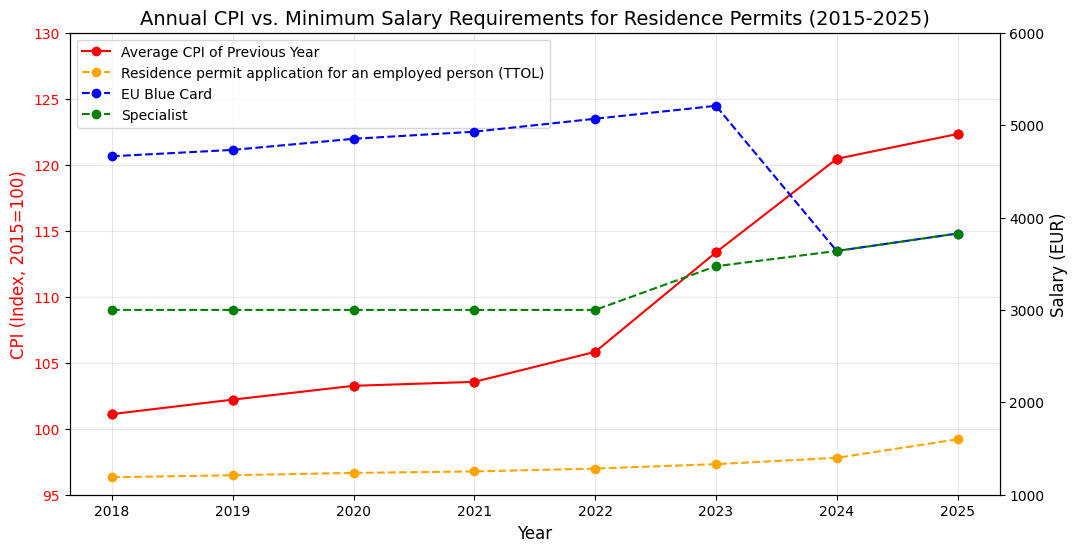

In [71]:

# Create the figure and primary y-axis for CPI
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot CPI on the left y-axis
ax1.plot(
    salaries_with_cpi_df['Year'], salaries_with_cpi_df['Average CPI of Previous Year'],
    label='Average CPI of Previous Year', marker='o', linestyle='-', color='red'
)
ax1.set_ylabel('CPI (Index, 2015=100)', fontsize=12, color='red')
ax1.set_xlabel('Year', fontsize=12)
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylim(95, 130)  # Adjust CPI range if necessary
ax1.grid(alpha=0.3)

# Secondary y-axis for salary data
ax2 = ax1.twinx()

# Define colors for each type
colors = {
    'EU Blue Card': 'blue',
    'Specialist': 'green',
    'Residence permit application for an employed person (TTOL)': 'orange'
}

# Plot latest salary data for each permit type
for permit_type in salaries_with_cpi_df['type_en'].unique():
    permit_data = salaries_with_cpi_df[salaries_with_cpi_df['type_en'] == permit_type]
    if not permit_data.empty:  # Ensure there is data to plot
        ax2.plot(
            permit_data['year'], permit_data['amount'],
            label=f'{permit_type}', marker='o', linestyle='--', color=colors[permit_type]
        )

ax2.set_ylabel('Salary (EUR)', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(1000, 6000)  # Adjust salary range as necessary

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

# Add title
plt.title('Annual CPI vs. Minimum Salary Requirements for Residence Permits (2015-2025)', fontsize=14)

# Show the plot
plt.show()


In [85]:
# Define the latest CPI (e.g., CPI of 2024-11 or the most recent data)
latest_cpi = cpi_beginning_of_year_df.iloc[-1]['CPI of Last Month of Previous Year']  # Adjust as necessary
print(f"Latest CPI (Last Month of Previous Year): {latest_cpi:.2f}")

# Create a DataFrame for adjusted salaries in today's money
adjusted_salaries_df = salaries_with_cpi_df.copy()

# Adjust salaries using CPI of the Last Month of Previous Year
adjusted_salaries_df['Adjusted Salary (Last Month CPI)'] = adjusted_salaries_df['amount'] * (
    latest_cpi / adjusted_salaries_df['CPI of Last Month of Previous Year']
)

# Adjust salaries using Average CPI of Previous Year
adjusted_salaries_df['Adjusted Salary (Average CPI)'] = adjusted_salaries_df['amount'] * (
    latest_cpi / adjusted_salaries_df['Average CPI of Previous Year']
)

# Select relevant columns for the final DataFrame
adjusted_salaries_df = adjusted_salaries_df[
    ['year', 'type_en', 'amount', 'Adjusted Salary (Last Month CPI)', 'Adjusted Salary (Average CPI)']
]

# Display the resulting DataFrame
display(adjusted_salaries_df.sort_values(by=['type_en', 'year']))


Latest CPI (Last Month of Previous Year): 122.47


,year,type_en,amount,Adjusted Salary (Last Month CPI),Adjusted Salary (Average CPI)
1,2018,EU Blue Card,4663,5625.826126,5648.175488
3,2019,EU Blue Card,4732,5642.372116,5670.297591
6,2020,EU Blue Card,4852,5732.990256,5755.153937
9,2021,EU Blue Card,4929,5810.517182,5829.548740
12,2022,EU Blue Card,5069,5775.424970,5866.385139
16,2023,EU Blue Card,5209,5437.659649,5627.530441
18,2024,EU Blue Card,3638,3665.837255,3699.087652
22,2025,EU Blue Card,3827,3827.000000,3831.436739
0,2018,Residence permit application for an employed p...,1189,1434.507241,1440.206017
4,2019,Residence permit application for an employed p...,1211,1443.979846,1451.126454


### Figure 4 - Annual CPI vs. Adjusted Minimum Salary Requirements for Residence Permits (2015-2025)

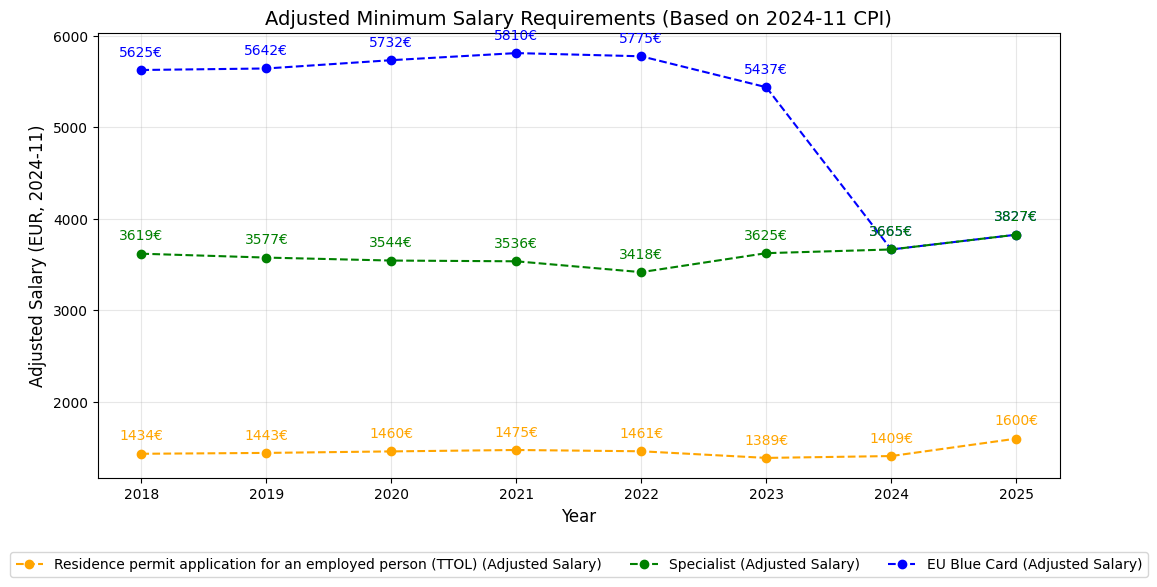

In [88]:
# Create the figure
plt.figure(figsize=(12, 6))

# Plot adjusted salary lines for each permit type
for permit_type in adjusted_salaries_df['type_en'].unique():
    permit_data = adjusted_salaries_df[salaries_with_cpi_df['type_en'] == permit_type]
    if not permit_data.empty:  # Ensure there is data to plot
        plt.plot(
            permit_data['year'], permit_data['Adjusted Salary (Last Month CPI)'],
            label=f'{permit_type} (Adjusted Salary)', marker='o', linestyle='--', color=colors.get(permit_type, 'gray')
        )
        # Annotate each point
        for _, row in permit_data.iterrows():
            plt.annotate(
                f"{int(row['Adjusted Salary (Last Month CPI)'])}€",  # Format as integer with €
                (row['year'], row['Adjusted Salary (Last Month CPI)']),
                textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color=colors.get(permit_type, 'gray')
            )

# Add labels and legend
plt.title('Adjusted Minimum Salary Requirements (Based on 2024-11 CPI)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Adjusted Salary (EUR, 2024-11)', fontsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

plt.grid(alpha=0.3)

# Adjust x and y limits if needed
plt.xticks(salaries_with_cpi_df['year'].unique())
plt.tight_layout()

# Show the plot
plt.show()


### Salary Requirements Adjusted for Inflation Since 2018
Here’s how to calculate the salary requirements if the 2018 numbers grow based solely on inflation, using the CPI to adjust each subsequent year's salary based on the CPI growth.

In [100]:
cpi_beginning_of_year_df.sample(5)

,Year,CPI of Last Month of Previous Year,Average CPI of Previous Year
3,2021,103.89,103.550833
4,2022,107.49,105.823333
1,2019,102.71,102.204167
7,2025,122.47,122.328182
0,2018,101.51,101.108333


In [134]:
base_year = 2018

# Get the latest actual salaries for all years from min_salaries_df
actual_salaries_df = min_salaries_df.sort_values(by='archive_date').drop_duplicates(subset=['type_en', 'year'], keep='last')

# Get the base salaries for 2018
base_salaries_df = actual_salaries_df[actual_salaries_df['year'] == base_year].copy()
base_cpi = cpi_beginning_of_year_df.loc[cpi_beginning_of_year_df['Year'] == base_year, 'CPI of Last Month of Previous Year'].values[0]
base_salaries_df['CPI'] = base_cpi
base_salaries_df.rename(columns={'amount': 'Actual Amount'}, inplace=True)
base_salaries_df['Adjusted Amount (based on CPI)'] = base_salaries_df['Actual Amount']  # Same as original amount for the base year

# Create a DataFrame to store adjusted salaries
adjusted_salaries_df = pd.DataFrame()

# Iterate over all years to calculate adjusted salaries
for year in cpi_beginning_of_year_df['Year']:
    # Get the actual salaries for the current year
    current_salaries_df = actual_salaries_df[actual_salaries_df['year'] == year].copy()

    # Get the CPI for the current year
    current_cpi = cpi_beginning_of_year_df.loc[cpi_beginning_of_year_df['Year'] == year, 'CPI of Last Month of Previous Year'].values[0]

    # Add CPI and calculate adjusted amounts
    if year > base_year:
        # Calculate the CPI ratio for adjusting the base salary
        cpi_ratio = current_cpi / base_cpi

        # Adjust salaries based on the 2018 base salary and CPI
        current_salaries_df['Adjusted Amount (based on CPI)'] = base_salaries_df.set_index('type_en').loc[
            current_salaries_df['type_en'], 'Actual Amount'
        ].values * cpi_ratio
    else:
        # For the base year, adjusted amount is the same as the actual amount
        current_salaries_df['Adjusted Amount (based on CPI)'] = current_salaries_df['amount']

    # Add CPI column
    current_salaries_df.rename(columns={'amount': 'Actual Amount'}, inplace=True)
    current_salaries_df['CPI'] = current_cpi

    # Append the results to the final DataFrame
    adjusted_salaries_df = pd.concat([adjusted_salaries_df, current_salaries_df], ignore_index=True)

# Sort the final DataFrame for clarity
adjusted_salaries_df = adjusted_salaries_df.sort_values(['type_en', 'year'])

# Display the resulting DataFrame
display(adjusted_salaries_df[['year', 'type_en', 'Actual Amount', 'CPI', 'Adjusted Amount (based on CPI)']])


,year,type_en,Actual Amount,CPI,Adjusted Amount (based on CPI)
1,2018,EU Blue Card,4663,101.51,4663.000000
5,2019,EU Blue Card,4732,102.71,4718.123633
8,2020,EU Blue Card,4852,103.65,4761.303812
11,2021,EU Blue Card,4929,103.89,4772.328539
14,2022,EU Blue Card,5069,107.49,4937.699438
16,2023,EU Blue Card,5209,117.32,5389.253867
20,2024,EU Blue Card,3638,121.54,5583.105310
22,2025,EU Blue Card,3827,122.47,5625.826126
2,2018,Residence permit application for an employed p...,1189,101.51,1189.000000
4,2019,Residence permit application for an employed p...,1211,102.71,1203.055758


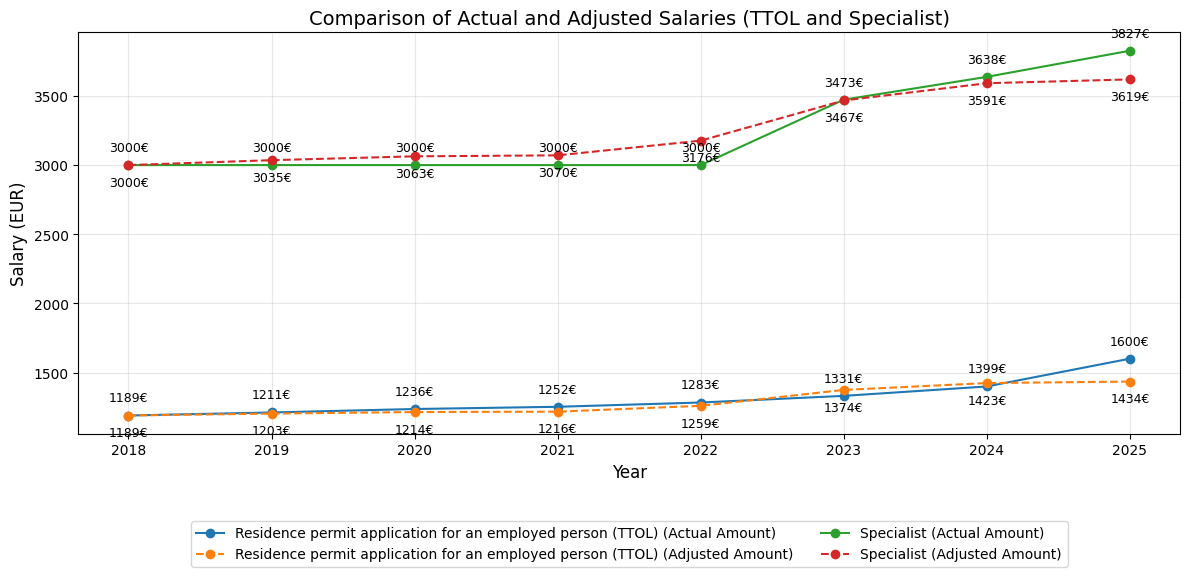

In [136]:
import matplotlib.pyplot as plt

# Filter data for TTOL and Specialist
filtered_data = adjusted_salaries_df[adjusted_salaries_df['type_en'].isin([
    'Residence permit application for an employed person (TTOL)',
    'Specialist'
])]

# Create the plot
plt.figure(figsize=(12, 6))

for permit_type in filtered_data['type_en'].unique():
    permit_data = filtered_data[filtered_data['type_en'] == permit_type]
    
    # Plot Actual Amount
    plt.plot(
        permit_data['year'], permit_data['Actual Amount'],
        label=f"{permit_type} (Actual Amount)", marker='o', linestyle='-'
    )
    
    # Annotate Actual Amount
    for _, row in permit_data.iterrows():
        plt.annotate(f"{int(row['Actual Amount'])}€", (row['year'], row['Actual Amount']),
                     textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9)
    
    # Plot Adjusted Amount (based on CPI)
    plt.plot(
        permit_data['year'], permit_data['Adjusted Amount (based on CPI)'],
        label=f"{permit_type} (Adjusted Amount)", marker='o', linestyle='--'
    )
    
    # Annotate Adjusted Amount
    for _, row in permit_data.iterrows():
        plt.annotate(f"{int(row['Adjusted Amount (based on CPI)'])}€", 
                     (row['year'], row['Adjusted Amount (based on CPI)']),
                     textcoords="offset points", xytext=(0, -15), ha='center', fontsize=9)

# Add labels, legend, and title
plt.title('Comparison of Actual and Adjusted Salaries (TTOL and Specialist)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Salary (EUR)', fontsize=12)

# Position legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fontsize=10, ncol=2)

# Add grid and adjust layout
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


### Analysis of Salary Growth for TTOL and Specialist vs. CPI

The growth in salary requirements for **TTOL** and **Specialist** permits has exceeded the rate of inflation, as indicated by the Consumer Price Index (CPI). While the CPI increased from **102.20 in 2018** to **122.47 in 2025**, representing a growth of approximately **20%**, the adjusted value of €3000 in 2018, based on this inflation, would be **€3619** in today's money. However, salary requirements for **Specialist** and **TTOL** have grown to **€3827** and **€1600**, respectively, surpassing the inflation-adjusted values.

It is important to note that since the **EU Blue Card** salary requirements were equalized to those of **Specialist** in 2024, they were excluded from this diagram to focus on TTOL and Specialist trends.

According to [Statistics Finland](https://stat.fi/en/statistics/khi), the latest CPI is **122.47**, while in 2018, it was **102.20**. In our calculations, the CPI for 2018 is slightly lower (**101.51**) because we calculated it using monthly data, as the official source provides only annual CPI values up to 2023. This method ensures better granularity in the analysis but introduces minor discrepancies compared to the annual official data.


## Part 4. Load Finland Average and Median Salary Data

This section integrates Finland's average and median salary data to evaluate the deviation of EU Blue Card salary requirements from these benchmarks. By calculating the percentage deviation, we can create an index that highlights how the salary thresholds align with economic realities over time. 

Given the ongoing recession and economic crises, it is crucial to recognize that salaries may not realistically keep pace with inflation rates. When determining minimum salary thresholds for work permits, such as the TTOL or Specialist, these economic constraints should be taken into account to ensure that the requirements remain attainable and reflect the broader labor market conditions. This analysis provides a foundation for data-driven and context-aware policy discussions.
